In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from scipy.optimize import minimize_scalar
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")

# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
dataset = data.to_numpy().astype(np.float32)  # Ensure data is float32 for PyTorch

GPU Name: Tesla P100-PCIE-16GB


Plot a diagram for showing the imbalance between number of fraud and non-fraud transactions.

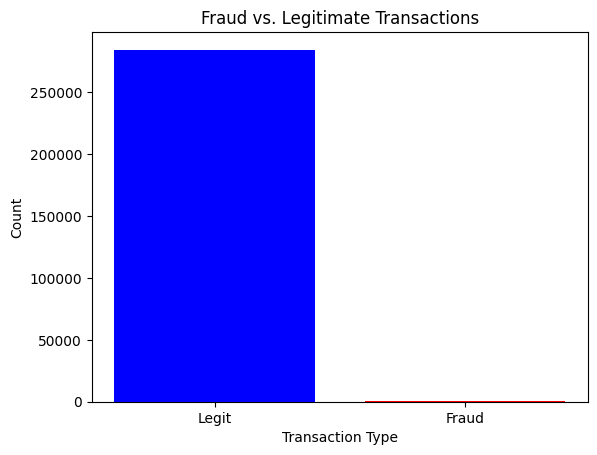

In [70]:
X, y = dataset[:, :-1], dataset[:, -1] 
fraud_count = np.bincount(y.astype(int))

plt.bar(["Legit", "Fraud"], fraud_count, color=["blue", "red"])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Fraud vs. Legitimate Transactions")
plt.show()

Perform PCA on the dataset and plot the projection of the transactions on the first two principal components.

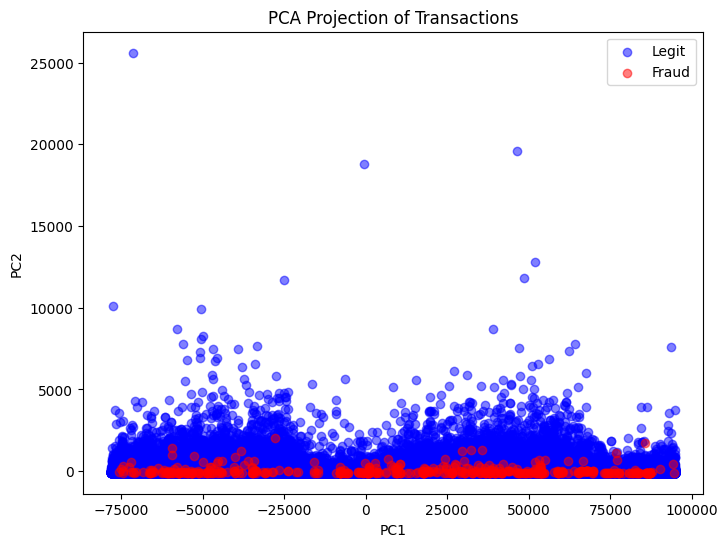

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)
fraud_mask = dataset[:, -1] == 1

plt.figure(figsize=(8, 6))
plt.scatter(components[~fraud_mask, 0], components[~fraud_mask, 1], alpha=0.5, color="blue", label="Legit")
plt.scatter(components[fraud_mask, 0], components[fraud_mask, 1], alpha=0.5, color="red", label="Fraud")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA Projection of Transactions")
plt.show()

In [72]:
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), unit_variance=False)
dataset[:, [0, 29]] = scaler.fit_transform(dataset[:, [0, 29]])

X = dataset[:, :-1]
y = dataset[:, -1]

# Convert to PyTorch tensors and move to GPU
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Split the data into 70% training and 30% testing

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor.cpu().numpy(), y_tensor.cpu().numpy(), test_size=0.2, random_state=42, stratify=y_tensor.cpu().numpy())

# Convert back to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the Autoencoder model

In [74]:
# -----------------------------
# 3. Define the Autoencoder Model
# -----------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: 30 -> 23 -> 19 -> 17 -> 8 with dropout after first two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(30, 23),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(23, 19),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(19, 17),
            nn.Tanh(),
            nn.Linear(17, 8)
        )
        # Decoder: 8 -> 17 -> 19 -> 23 -> 30 with dropout after first two layers
        self.decoder = nn.Sequential(
            nn.Linear(8, 17),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(17, 19),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(19, 23),
            nn.Tanh(),
            nn.Linear(23, 30)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [75]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Ensure tensors are converted to NumPy before using NumPy functions
y_train_np = y_train.cpu().numpy()  # Move y_train from CUDA to CPU and convert to NumPy
data_train_np = X_train.cpu().numpy()  # Move data_train from CUDA to CPU

# Get fraud and non-fraud data using y_train
fraud_indices = np.where(y_train_np == 1)[0]
non_fraud_indices = np.where(y_train_np == 0)[0]

fraud_data = data_train_np[fraud_indices]
non_fraud_data = data_train_np[non_fraud_indices]

# Calculate number of fraud samples for later use
n = len(fraud_data)
print(f"Number of fraud samples in training data: {n}")

# Select an equal number of non-fraud samples
non_fraud_data_limited = non_fraud_data[:n]

# Combine the selected data
X_balanced = np.vstack((non_fraud_data_limited, fraud_data))
y_balanced = np.hstack((np.zeros(n), np.ones(n)))  # Create labels: 0 for non-fraud, 1 for fraud

# Shuffle the data
shuffle_idx = np.random.permutation(len(X_balanced))
X_balanced_shuffled = X_balanced[shuffle_idx]
y_balanced_shuffled = y_balanced[shuffle_idx]

# Split into training and test sets for SVM
data_train_SVM, data_test_SVM, labels_train_SVM, labels_test_SVM = train_test_split(
    X_balanced_shuffled, y_balanced_shuffled, test_size=0.2, random_state=42
)

# Train SVM model for validation in the oversampling process
model = SVC(kernel='linear', C=1.0)
model.fit(data_train_SVM, labels_train_SVM)

# Get predictions and accuracy
labels_pred_test = model.predict(data_test_SVM)
labels_pred_train = model.predict(data_train_SVM)
accuracy_train = np.mean(labels_pred_train == labels_train_SVM)
accuracy_test = np.mean(labels_pred_test == labels_test_SVM)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")


Number of fraud samples in training data: 394
Train Accuracy: 0.9698
Test Accuracy: 0.9304


# Balanced the dataset

In [37]:
# Move y_train to CPU for NumPy operations
y_train_np = y_train.cpu().numpy()
X_train_np = X_train.cpu().numpy()

# -----------------------------
# 1. Balance the dataset (Undersample non-fraud cases)
# -----------------------------

# Get indices of fraud and non-fraud cases
fraud_indices = np.where(y_train_np == 1)[0]
non_fraud_indices = np.where(y_train_np == 0)[0]

# Extract fraud and non-fraud samples
fraud_data = X_train_np[fraud_indices]
non_fraud_data = X_train_np[non_fraud_indices]

# Balance the dataset by selecting an equal number of non-fraud samples
n = len(fraud_data)
print(f"Number of fraud samples in training data: {n}")

non_fraud_data_limited = non_fraud_data[:n]

# Combine the balanced data
X_balanced = np.vstack((non_fraud_data_limited, fraud_data))
y_balanced = np.hstack((np.zeros(n), np.ones(n)))  # Labels: 0 for non-fraud, 1 for fraud

# Shuffle the data
shuffle_idx = np.random.permutation(len(X_balanced))
X_balanced = X_balanced[shuffle_idx].astype(np.float32)
y_balanced = y_balanced[shuffle_idx].astype(np.float32)

# -----------------------------
# 2. Split into training and test sets for SVM
# -----------------------------
data_train_SVM, data_test_SVM, labels_train_SVM, labels_test_SVM = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# -----------------------------
# 3. Train an SVM Model
# -----------------------------
model = SVC(kernel='linear', C=1.0)
model.fit(data_train_SVM, labels_train_SVM)

# -----------------------------
# 4. Evaluate Model
# -----------------------------
labels_pred_train = model.predict(data_train_SVM)
labels_pred_test = model.predict(data_test_SVM)

accuracy_train = np.mean(labels_pred_train == labels_train_SVM)
accuracy_test = np.mean(labels_pred_test == labels_test_SVM)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Number of fraud samples in training data: 394
Train Accuracy: 0.9556
Test Accuracy: 0.9810


# To speed up the development process, use the saved dataset

In [76]:
# -----------------------------
# 1. Load Balanced Data
# -----------------------------
data_train_oversampled = np.load("/kaggle/input/data-train-balanced/data_train_balanced.npy")
labels_train_oversampled = np.load("/kaggle/input/y-train-balanced/y_train_balanced.npy")

# Ensure correct data type
data_train_oversampled = data_train_oversampled.astype(np.float32)
labels_train_oversampled = labels_train_oversampled.astype(np.float32)

# -----------------------------
# 2. Convert to PyTorch Tensors & Move to GPU
# -----------------------------
X_train_balanced = torch.tensor(data_train_oversampled, dtype=torch.float32).to(device)
y_train_balanced = torch.tensor(labels_train_oversampled, dtype=torch.float32).to(device)

# Print confirmation
print(f"Balanced data loaded successfully! 🚀")
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")
print(f"Data is on device: {device}")


Balanced data loaded successfully! 🚀
X_train_balanced shape: torch.Size([398081, 30])
y_train_balanced shape: torch.Size([398081])
Data is on device: cuda


# Train the ALSTM model

In [77]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):
        """
        lstm_output: (batch_size, seq_len, hidden_size)
        Returns:
            context: (batch_size, hidden_size) - Weighted sum of LSTM outputs
        """
        # Ensure lstm_output is at least 3D
        if lstm_output.dim() == 2:
            lstm_output = lstm_output.unsqueeze(1)  # Add sequence length dimension
        
        # Compute attention scores
        attention_scores = self.attention_weights(lstm_output)  # (batch_size, seq_len, 1)

        # Ensure attention_scores does not lose dimensions
        attention_scores = attention_scores.squeeze(-1) if attention_scores.dim() > 2 else attention_scores

        # Apply softmax over the sequence dimension
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)  # Safe indexing

        # Compute context vector (batch_size, hidden_size)
        context = torch.einsum("bsh,bs->bh", lstm_output, attention_weights)

        return context

class ALSTM(nn.Module):
    def __init__(self, input_size=30, hidden_size=10):
        super(ALSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Define LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        # Attention layer
        self.attention = Attention(hidden_size)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)

        # Sigmoid activation for final output
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        Returns:
            out: (batch_size, 1) - Predicted output
        """
        # Ensure input is on GPU
        x = x.to(device)

        # LSTM forward pass
        lstm_out, (h, c) = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)

        # Apply attention
        context = self.attention(lstm_out)  # (batch_size, hidden_size)

        # Pass through fully connected layer
        logits = self.fc(context)  # (batch_size, 1)

        # Apply sigmoid activation
        out = self.sigmoid(logits)

        return out


In [85]:
def train_model(model, X, y, num_epochs=100, batch_size=64, lr=0.001):
    # Move model to GPU
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Ensure tensors are properly detached before copying
    # Ensure tensors are on CPU before creating TensorDataset
    X_train_cpu = X_train.to("cpu")
    y_train_cpu = y_train.to("cpu")
    
    # Create dataset using CPU tensors
    train_dataset = TensorDataset(X_train_cpu, y_train_cpu)
    
    # Create DataLoader with num_workers=0
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
    
    # Use Mixed Precision Training
    scaler = torch.amp.GradScaler("cuda")

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0

        # Training loop
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move to GPU inside loop

            optimizer.zero_grad()

            # Forward pass with mixed precision
            with torch.amp.autocast("cuda"):
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

            # Backward pass with mixed precision scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # Print loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')

    return model


# Gradient Boosting Classifier

**Input:** Training set $T = \{(x_i, y_i)\}_{i=1}^m$, ALSTM as base learner, number of estimators $(n\_estimators)$

Initialize $h^0(x)$ with a constant: $h^0(x) = \arg \min \sum_{i=1}^n L(y_i, 0)$

**for** $t = 1, \ldots, n\_estimators$ **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Compute residuals: $r_i^t = -\frac{\partial L}{\partial h^{t-1}(x_i)}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train $ALSTM_t(x)$ using the dataset $(x_i, r_i^t)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate step length: $\alpha^t = \arg \min_\alpha \sum_{i=1}^n L(y_i, h^{t-1}(x_i) + \alpha h^t(x_i))$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Update the model: $h(x) = h(x) + \alpha^t h_t(x)$

**end for**

**Output:** Final ensemble model $h(x)$

Sì. Se la tua funzione di costo è

$$
L = \tfrac12 \sum_{i=1}^{n} \bigl(y_i - \hat{y}_i\bigr)^2,
$$

allora, quando vuoi scegliere **una costante** \(c\) che minimizzi la somma dei quadrati degli errori (senza dipendenza da $x$), il valore ottimale è la **media di $y$**:

$$
c^* \;=\; \arg\min_{c}\; \tfrac12 \sum_{i=1}^{n} (y_i - c)^2
\;=\;
\frac{1}{n} \sum_{i=1}^n y_i.
$$

Quindi, nel caso del Gradient Boosting con questa loss (che è sostanzialmente l’errore quadratico medio, a parte il fattore $\tfrac12$), **inizializzare $h^0(x)$ con la media di $y$ è corretto**.

In [79]:
def GB_classifier(X, y, n_estimators=10):
    estimators = []

    # Move input data to GPU
    X = X.to(device)
    y = y.to(device)

    loss_fn = lambda y, yhat: 1/2 * torch.sum((y - yhat)**2)

    hx = torch.full((len(y),), torch.mean(y), dtype=torch.float32, device=device)

    for t in range(n_estimators):
        # Compute residuals and move them to GPU
        residuals = -(y - hx).to(device)

        # Initialize model and move it to GPU
        model_t = ALSTM(input_size=30, hidden_size=10).to(device)

        # Train model
        train_model(model_t, X, residuals, num_epochs=2)

        # Predict residuals on GPU
        model_t.eval()
        with torch.no_grad():
            predictions = model_t(X).squeeze()
        
        h_t = predictions  # Already on GPU

        # Compute step length on GPU
        func = lambda alpha: torch.sum(loss_fn(y, hx + alpha * h_t))
        alpha_t = torch.tensor(minimize_scalar(func, method="golden").x, dtype=torch.float32, device=device)

        # Update hx on GPU
        hx += alpha_t * h_t

        print(f"a_{t+1} = {alpha_t.item():.4f}")

        estimators.append((model_t, alpha_t))

    return estimators


In [86]:
# Convert loaded NumPy arrays to PyTorch tensors and move to GPU
X_train_balanced = torch.tensor(data_train_oversampled, dtype=torch.float32).to(device)
y_train_balanced = torch.tensor(labels_train_oversampled, dtype=torch.float32).to(device)

# Train Gradient Boosting Classifier with ALSTM on GPU
estimators = GB_classifier(X_train_balanced, y_train_balanced, n_estimators=6)

print("Gradient Boosting with ALSTM completed! 🚀")

Epoch [1/2], Loss: 39.63629183150533
Epoch [2/2], Loss: 6.334793070476508


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_SUPPORTED. This error may appear if you passed in a non-contiguous input.

In [ ]:
# evaluate the model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

hx = np.full(len(data_test), np.mean(labels_train_oversampled), dtype=np.float32)

# hx = np.zeros(len(data_test), dtype=np.float32)

# Go through each model in the trained ensemble
for model, alpha in estimators:
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(data_test).to(device)
        prediction = model(X_tensor).numpy().flatten()
    
    hx += alpha * prediction

y_pred_binary = np.where(hx > 0.5, 1, 0)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

[2.8368775e-04 2.4022738e-05 4.3083844e-04 ... 2.4452747e-05 5.2934654e-05
 9.2257324e-05]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.9984


In [80]:
# find the True Positives
TP = np.sum((y_test == 1) & (y_pred_binary == 1))
print(f"True Positives: {TP}")
# find False Positives
FP = np.sum((y_test == 0) & (y_pred_binary == 1))
print(f"False Positives: {FP}")
# find False Negatives
FN = np.sum((y_test == 1) & (y_pred_binary == 0))
print(f"False Negatives: {FN}")
# find True Negatives
TN = np.sum((y_test == 0) & (y_pred_binary == 0))
print(f"True Negatives: {TN}")

# calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.4f}")
# calculate the precision
precision = TP / (TP + FP)
print(f"Precision: {precision:.4f}")
# calculate the recall
recall = TP / (TP + FN)
print(f"Recall: {recall:.4f}")
# calculate the F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1:.4f}")

True Positives: 85
False Positives: 14
False Negatives: 51
True Negatives: 85293
Accuracy: 0.9992
Precision: 0.8586
Recall: 0.6250
F1 Score: 0.7234


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add after your existing metrics
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.9984


/Users/beatricezani/Desktop/pythonProject/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
